## Skorch backprop network

In [3]:

import subprocess

# Installation on Google Colab
!git clone https://github.com/jlm429/pyperch


fatal: destination path 'pyperch' already exists and is not an empty directory.


In [1]:
import numpy as np
from sklearn.datasets import make_classification
from torch import nn, optim
from skorch import NeuralNetClassifier
from pyperch.pyperch.neural.backprop_nn import BackpropModule
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
X1 = pd.read_csv('bankmarketing_X.csv')
X2 = pd.read_csv('breastcancer_X.csv')
Y1 = pd.read_csv('bankmarketing_Y.csv')
Y2 = pd.read_csv('breastcancer_Y.csv')

In [3]:
X1 = X1.map(lambda x: int(x) if isinstance(x, bool) else x)

In [4]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,Y1,test_size = 0.2, random_state=42,stratify=Y1)

In [5]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,Y2,test_size = 0.2, random_state=42,stratify=Y2)

In [6]:
X1_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3617 entries, 572 to 2252
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   education          3617 non-null   int64
 1   default            3617 non-null   int64
 2   balance            3617 non-null   int64
 3   housing            3617 non-null   int64
 4   loan               3617 non-null   int64
 5   duration           3617 non-null   int64
 6   campaign           3617 non-null   int64
 7   pdays              3617 non-null   int64
 8   poutcome           3617 non-null   int64
 9   job_admin.         3617 non-null   int64
 10  job_blue-collar    3617 non-null   int64
 11  job_entrepreneur   3617 non-null   int64
 12  job_housemaid      3617 non-null   int64
 13  job_management     3617 non-null   int64
 14  job_retired        3617 non-null   int64
 15  job_self-employed  3617 non-null   int64
 16  job_services       3617 non-null   int64
 17  job_student      

In [7]:
y1_train

,y
572,0
3152,0
4170,0
461,0
172,0
...,...
413,0
1862,0
3463,0
2954,0


In [48]:
from skorch.callbacks import EpochScoring
from skorch.callbacks import Callback

net = NeuralNetClassifier(
    module=BackpropModule,
    module__input_dim=23,
    module__output_dim=2,
    module__hidden_units=1,
    module__hidden_layers=1,
    max_epochs=100,
    verbose=1,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),],
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.SGD,
    lr=.05,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

In [49]:
#    module__hidden_units=1,
#    module__hidden_layers=1,
net.fit(X1_train.values.astype(np.float32), y1_train.values.ravel().astype(np.int64))
y_proba = net.predict_proba(X1_test.values.astype(np.float32))

  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.1168        0.9237       0.1174        0.8707  0.0427


      2       0.1168        0.8268       0.1174        0.7729  0.0461
      3       0.2288        0.7280       0.8135        0.6820  0.0415
      4       0.8431        0.6473       0.8826        0.6140  0.0425
      5       0.8832        0.5904       0.8826        0.5686  0.0408
      6       0.8832        0.5529       0.8826        0.5387  0.0734
      7       0.8832        0.5280       0.8826        0.5185  0.0527
      8       0.8832        0.5108       0.8826        0.5043  0.0423
      9       0.8832        0.4985       0.8826        0.4938  0.0424
     10       0.8832        0.4892       0.8826        0.4858  0.0426
     11       0.8832        0.4821       0.8826        0.4795  0.0414
     12       0.8832        0.4765       0.8826        0.4746  0.0416
     13       0.8832        0.4720       0.8826        0.4705  0.0428
     14       0.8832        0.4683       0.8826        0.4671  0.0403
     15       0.8832        0.4651       0.8826        0.4642  0.0423
     16       0.8832

In [15]:
y_proba

array([[0.6965719 , 0.30342817],
       [0.6965719 , 0.30342817],
       [0.6965719 , 0.30342817],
       ...,
       [0.6965719 , 0.30342817],
       [0.6965719 , 0.30342817],
       [0.7102152 , 0.2897848 ]], dtype=float32)

In [52]:
   # module__hidden_units=100,
   # module__hidden_layers=100,
net = NeuralNetClassifier(
    module=BackpropModule,
    module__input_dim=23,
    module__output_dim=2,
    module__hidden_units=100,
    module__hidden_layers=100,
    max_epochs=100,
    verbose=1,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),],
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.SGD,
    lr=.05,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,)

In [53]:
net.fit(X1_train.values.astype(np.float32), y1_train.values.ravel().astype(np.int64))
y_proba = net.predict_proba(X1_test.values.astype(np.float32))

  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.8479        0.6468       0.8826        0.5994  2.3424
      2       0.8832        0.5696       0.8826        0.5422  2.3544
      3       0.8832        0.5242       0.8826        0.5077  2.4092
      4       0.8832        0.4965       0.8826        0.4865  2.3363
      5       0.8832        0.4791       0.8826        0.4726  2.2413
      6       0.8832        0.4675       0.8826        0.4633  2.3347
      7       0.8832        0.4596       0.8826        0.4567  2.2574
      8       0.8832        0.4539       0.8826        0.4520  2.3045
      9       0.8832        0.4497       0.8826        0.4485  2.2545
     10       0.8832        0.4466       0.8826        0.4457  2.2541
     11       0.8832        0.4442       0.8826        0.4436  2.3485
     12       0.8832        0.4423       0.8826        0.4419  2.2382
     13       0.8832

In [57]:
#

net = NeuralNetClassifier(
    module=BackpropModule,
    module__input_dim=23,
    module__output_dim=2,
    module__hidden_units=1,
    module__hidden_layers=1,
    max_epochs=100,
    verbose=1,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),],
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.SGD,
    lr=.005,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,)
net.fit(X1_train.values.astype(np.float32), y1_train.values.ravel().astype(np.int64))
y_proba = net.predict_proba(X1_test.values.astype(np.float32))

  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.1168        0.9201       0.1174        0.9102  0.0413
      2       0.1168        0.9050       0.1174        0.8948  0.0479


      3       0.1168        0.8895       0.1174        0.8793  0.0495
      4       0.1168        0.8740       0.1174        0.8635  0.0424
      5       0.1168        0.8583       0.1174        0.8475  0.0426
      6       0.1168        0.8426       0.1174        0.8315  0.0442
      7       0.1168        0.8268       0.1174        0.8152  0.0413
      8       0.1168        0.8109       0.1174        0.7988  0.0417
      9       0.1168        0.7950       0.1174        0.7824  0.0502
     10       0.1168        0.7790       0.1174        0.7664  0.0564
     11       0.1168        0.7632       0.1174        0.7510  0.0452
     12       0.1168        0.7475       0.1174        0.7359  0.0415
     13       0.1168        0.7323       0.1174        0.7214  0.0413
     14       0.1168        0.7175       0.1174        0.7072  0.0416
     15       0.2962        0.7028       0.8674        0.6932  0.0430
     16       0.8662        0.6888       0.8715        0.6801  0.0413
     17       0.8707

In [69]:

net = NeuralNetClassifier(
    module=BackpropModule,
    module__input_dim=23,
    module__output_dim=2,
    module__hidden_units=1,
    module__hidden_layers=1,
    max_epochs=100,
    verbose=1,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),],
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.SGD,
    lr=.005,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,)
net.fit(X1_train.values.astype(np.float32), y1_train.values.ravel().astype(np.int64))
y_proba = net.predict_proba(X1_test.values.astype(np.float32))



  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.8832        0.5917       0.8826        0.5806  0.0453
      2       0.8832        0.5801       0.8826        0.5691  0.0421


      3       0.8832        0.5685       0.8826        0.5571  0.0491
      4       0.8832        0.5524       0.8826        0.5421  0.0434
      5       0.8832        0.5261       0.8826        0.5030  0.0449
      6       0.8832        0.4573       0.8826        0.4474  0.0422
      7       0.8832        0.4460       0.8826        0.4459  0.0429
      8       0.8832        0.4448       0.8826        0.4448  0.0439
      9       0.8832        0.4441       0.8826        0.4438  0.0426
     10       0.8832        0.4433       0.8826        0.4432  0.0435
     11       0.8832        0.4426       0.8826        0.4427  0.0422
     12       0.8832        0.4419       0.8826        0.4421  0.0420
     13       0.8832        0.4414       0.8826        0.4415  0.0414
     14       0.8832        0.4409       0.8826        0.4411  0.0425
     15       0.8832        0.4405       0.8826        0.4406  0.0422
     16       0.8832        0.4402       0.8826        0.4402  0.0416
     17       0.8832

## Plot learning curves

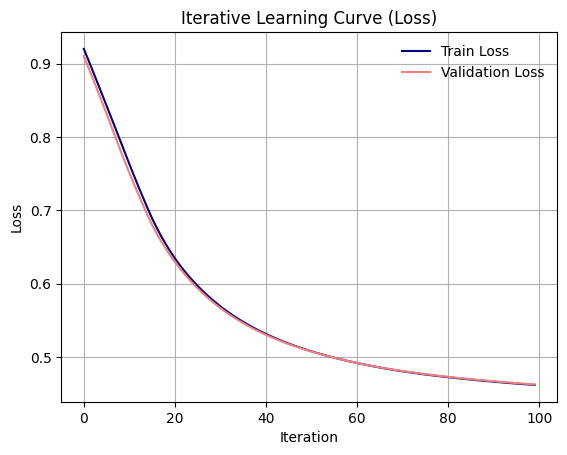

In [58]:
#10 Iterations
# plot the iterative learning curve (loss)
plt.plot(net.history[:, 'train_loss'], label='Train Loss', color='navy')
plt.plot(net.history[:, 'valid_loss'], label='Validation Loss', color='lightcoral')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iterative Learning Curve (Loss)")
plt.grid(visible=True)
plt.legend(frameon=False)

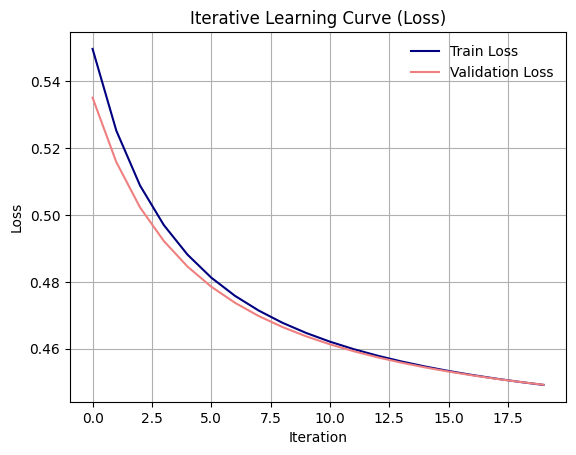

In [19]:
#20 iterarions
plt.plot(net.history[:, 'train_loss'], label='Train Loss', color='navy')
plt.plot(net.history[:, 'valid_loss'], label='Validation Loss', color='lightcoral')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iterative Learning Curve (Loss)")
plt.grid(visible=True)
plt.legend(frameon=False)

(0.43, 0.48)

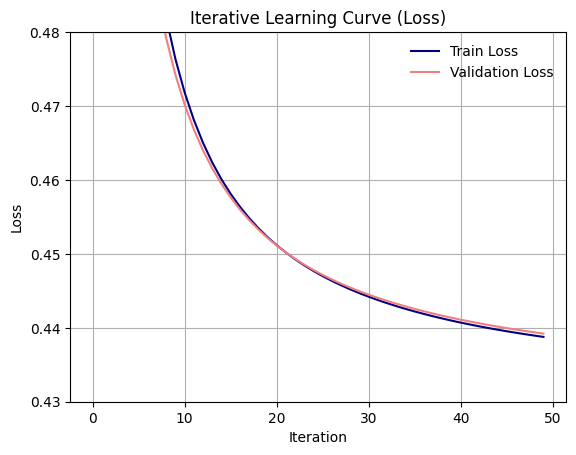

In [32]:
#50 iterations
plt.plot(net.history[:, 'train_loss'], label='Train Loss', color='navy')
plt.plot(net.history[:, 'valid_loss'], label='Validation Loss', color='lightcoral')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iterative Learning Curve (Loss)")
plt.grid(visible=True)
plt.legend(frameon=False)
plt.ylim([0.43, 0.48])


In [34]:
plt.figure(figsize=(10, 6))
difference = np.abs(net.history[:, 'train_loss'] - net.history[:, 'valid_loss'])
plt.plot(iterations, difference, label='Absolute Difference', color='green')

NameError: name 'epoch_logger' is not defined

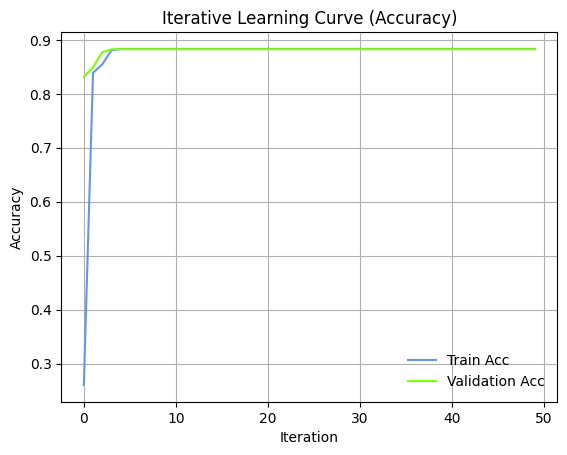

In [33]:
# plot the iterative learning curve (accuracy)
plt.plot(net.history[:, 'train_acc'], label='Train Acc', color='cornflowerblue')
plt.plot(net.history[:, 'valid_acc'], label='Validation Acc', color='chartreuse')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Iterative Learning Curve (Accuracy)")
plt.grid(visible=True)
plt.legend(frameon=False)
plt.ylim([0.43, 0.48])

## Using sklearn learning curve with RO

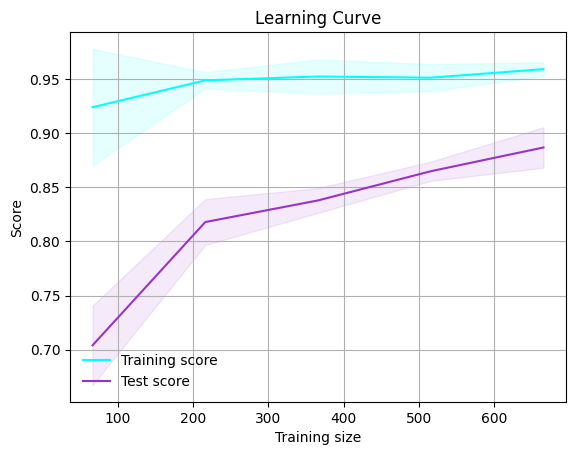

In [ ]:
from sklearn.model_selection import learning_curve

# Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    net, X, y, train_sizes=np.linspace(0.1, 1.0, 5), cv=3
)

train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='cyan')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='darkorchid')
plt.plot(train_sizes, train_scores_mean, label="Training score", color='cyan')
plt.plot(train_sizes, test_scores_mean, label="Test score", color='darkorchid')
plt.title("Learning Curve")
plt.xlabel("Training size")
plt.ylabel("Score")
plt.grid(visible=True)
plt.legend(frameon=False)

## Using sklearn pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('net', net),
])

pipe.fit(X, y)
y_proba = pipe.predict_proba(X)

## Using sklearn grid search

In [ ]:
from sklearn.model_selection import GridSearchCV

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0)

default_params = {
    'module__input_dim': [12],
    'module__output_dim': [2],
}

# module specific parameters need to begin with 'module__'
params = {
    'lr': [0.01, 0.02],
    'max_epochs': [10, 20],
    'module__hidden_units': [10, 20],
    **default_params,
}
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy', verbose=2)

gs.fit(X, y)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END lr=0.01, max_epochs=10, module__hidden_units=10, module__input_dim=12, module__output_dim=2; total time=   0.2s
[CV] END lr=0.01, max_epochs=10, module__hidden_units=10, module__input_dim=12, module__output_dim=2; total time=   0.2s
[CV] END lr=0.01, max_epochs=10, module__hidden_units=10, module__input_dim=12, module__output_dim=2; total time=   0.2s
[CV] END lr=0.01, max_epochs=10, module__hidden_units=20, module__input_dim=12, module__output_dim=2; total time=   0.2s
[CV] END lr=0.01, max_epochs=10, module__hidden_units=20, module__input_dim=12, module__output_dim=2; total time=   0.2s
[CV] END lr=0.01, max_epochs=10, module__hidden_units=20, module__input_dim=12, module__output_dim=2; total time=   0.2s
[CV] END lr=0.01, max_epochs=20, module__hidden_units=10, module__input_dim=12, module__output_dim=2; total time=   0.4s
[CV] END lr=0.01, max_epochs=20, module__hidden_units=10, module__input_dim=12, module__outpu